In [0]:
!pip uninstall torch --yes
!pip3 uninstall torch --yes
!pip3 install torch torchvision

In [0]:
import sys, os
try:
  sys.path.remove('/usr/local/lib/python3.6/dist-packages/torch/optim')
except ValueError:
  sys.path.append('/usr/local/lib/python3.6/dist-packages/torch/optim')

In [0]:
#couldn't find a nicer way to put custom optimizers into pytorch module. Spent too long trying. Ugly method ftw

#sys.path.append('/usr/local/lib/python3.6/dist-packages/torch/optim')

import math
import torch
from optimizer import Optimizer


class AMSAggMo(Optimizer):
    """Implements AMSgrad algorithm with Aggregated Momentum.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_

    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, beta1=[0, 0.9, 0.99], beta2=0.999, eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        for i, beta in enumerate(beta1):
            if not 0.0 <= beta < 1.0:
                raise ValueError("Invalid beta1 parameter at index {}: {}".format(i, beta))
        if not 0.0 <= beta2 < 1.0:
            raise ValueError("Invalid beta2 parameter: {}".format(beta2))
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(AMSAggMo, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AMSAggMo, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
                            
            beta1 = group['beta1']
            beta2 = group['beta2']
            
            max_beta = max(beta1)
            
            #print(avg_mom)
            
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = {}
                    for beta in beta1:
                        state['exp_avg'][beta] =  torch.zeros_like(p.data)
                        
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state['max_exp_avg_sq'] = torch.zeros_like(p.data)
                    
                exp_avg_sq = state['exp_avg_sq']
                max_exp_avg_sq = state['max_exp_avg_sq']
                
                state['step'] += 1

                exp_avg = torch.zeros_like(p.data)
                
                # Decay the first and second moment running average coefficient
                bias_correction1 = 0
                for beta in beta1:
                    buf = state['exp_avg'][beta]   
                    buf.mul_(beta).add_(1 - beta, grad)
                    exp_avg += buf/len(beta1)
                    bias_correction1 += (1 - beta**state['step'])/len(beta1)

                
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                # Maintains the maximum of all 2nd moment running avg. till now
                torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                # Use the max. for normalizing running avg. of gradient
                denom = max_exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                #print('exp_avg')
                #print(exp_avg)
                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss
from optimizer import Optimizer, required


class AggMo(Optimizer):
    r"""Implements Aggregated Momentum Gradient Descent,
    as proposed in `Aggregated Momentum: Stability Through Passive Damping`_.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (list, optional): damping vector (default: [0, 0.9, 0.99])
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    Example:
        >>> optimizer = torch.optim.AggMo(model.parameters(), lr=0.1, momentum=[0,0.9,0.99,0.999])
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    .. _Aggregated Momentum: Stability Through Passive Damping:
        https://arxiv.org/abs/1804.00325
    """

    def __init__(self, params, lr=required, momentum=[0.0, 0.9, 0.99], weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        for i, mom in enumerate(momentum):
            if not 0.0 <= mom:
                raise ValueError("Invalid momentum parameter at index {}: {}".format(i, mom))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay)
        super(AggMo, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AggMo, self).__setstate__(state)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            total_mom = float(len(momentum))

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    param_state['momentum_buffer'] = {}
                    for beta in momentum:
                        param_state['momentum_buffer'][beta] = torch.zeros_like(p.data)
                for beta in momentum:
                    buf = param_state['momentum_buffer'][beta]
                    buf.mul_(beta).add_(d_p)
                    p.data.sub_(group['lr'] / total_mom, buf)
        return loss




In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
#load test and train data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(torch.cuda.is_available())

True


In [0]:
#SGD with Nesterov, Adam, AMSGrad, AMSAggMo and AggMo
net, net1, net2, net3, net4 = Net(), Net(), Net(), Net(), Net()

#setup GPU use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.99, nesterov = True)
optimizer2 = optim.Adam(net2.parameters(), lr=0.0001, amsgrad = True, betas = (0.99,0.999))
optimizer3 = AMSAggMo(net3.parameters(), lr=0.0001, beta1 = [0,0.9,0.99])
optimizer4 = AggMo(net4.parameters(), lr = 0.0001, momentum = [0,0.9,0.99])

epochs = 10

In [7]:
net = net.to(device)
sgd_loss = np.zeros([1,epochs])
total = time.time()
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    avg_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        avg_loss += loss.item()
        if i % 12000 == 11999:    # print every 12000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 12000))
            running_loss = 0.0
    sgd_loss[0,epoch] = avg_loss/(i+1)

print('Finished TrainingNesterov SGD. Time:', time.time()-total,'s')

[1, 12000] loss: 1.737
[2, 12000] loss: 1.346
[3, 12000] loss: 1.209
[4, 12000] loss: 1.111
[5, 12000] loss: 1.046
[6, 12000] loss: 0.997
[7, 12000] loss: 0.938
[8, 12000] loss: 0.908
[9, 12000] loss: 0.870
[10, 12000] loss: 0.834
Finished TrainingNesterov SGD. Time: 942.5618979930878 s


In [8]:
net2 = net2.to(device)
amsg_loss = np.zeros([1,epochs])
total = time.time()
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    avg_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer2.zero_grad()

        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()

        # print statistics
        running_loss += loss.item()
        avg_loss += loss.item()
        if i % 12000 == 11999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 12000))
            running_loss = 0.0
    amsg_loss[0,epoch] = avg_loss/(i+1)

print('Finished Training AmsGrad. Time:', time.time()-total,'s')

[1, 12000] loss: 1.780
[2, 12000] loss: 1.509
[3, 12000] loss: 1.411
[4, 12000] loss: 1.338
[5, 12000] loss: 1.279
[6, 12000] loss: 1.229
[7, 12000] loss: 1.187
[8, 12000] loss: 1.148
[9, 12000] loss: 1.114
[10, 12000] loss: 1.085
Finished Training AmsGrad. Time: 1120.7834362983704 s


In [9]:
net3 = net3.to(device)
amsaggmo_loss = np.zeros([1,epochs])
total = time.time()
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    avg_loss  = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer3.zero_grad()

        # forward + backward + optimize
        outputs = net3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer3.step()

        # print statistics
        running_loss += loss.item()
        avg_loss += loss.item()
        if i % 12000 == 11999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 12000))
            running_loss = 0.0
    amsaggmo_loss[0,epoch] = avg_loss / (i+1)


print('Finished Training AMSAggMo. Time:', time.time()-total,'s')

[1, 12000] loss: 1.745
[2, 12000] loss: 1.483
[3, 12000] loss: 1.377
[4, 12000] loss: 1.300
[5, 12000] loss: 1.237
[6, 12000] loss: 1.187
[7, 12000] loss: 1.141
[8, 12000] loss: 1.105
[9, 12000] loss: 1.070
[10, 12000] loss: 1.039
Finished Training AMSAggMo. Time: 1684.5636994838715 s


In [10]:
net4 = net4.to(device)
aggmo_loss = np.zeros([1,epochs])
total = time.time()
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    avg_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer4.zero_grad()

        # forward + backward + optimize
        outputs = net4(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer4.step()

        # print statistics
        running_loss += loss.item()
        avg_loss += loss.item()
    if epoch % 2 == 1:    # print every 10 epochs
        print('end of epoch %d loss: %.3f' % (epoch + 1, running_loss / 15000))
    running_loss = 0.0
    aggmo_loss[0,epoch] = avg_loss/(i+1)

print('Finished Training AggMo. Time:', time.time()-total,'s')

end of epoch 2 loss: 1.216
end of epoch 4 loss: 0.975
end of epoch 6 loss: 0.858
end of epoch 8 loss: 0.775
end of epoch 10 loss: 0.707
Finished Training AggMo. Time: 1131.787795305252 s


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of SGD-N on the 10000 test images: %d %%' % (
    100 * correct / total))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of AmsGrad on the 10000 test images: %d %%' % (
    100 * correct / total))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net3(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of AMSAggmo on the 10000 test images: %d %%' % (
    100 * correct / total))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net4(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of AggMo on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of SGD-N on the 10000 test images: 63 %
Accuracy of AmsGrad on the 10000 test images: 59 %
Accuracy of AMSAggmo on the 10000 test images: 60 %
Accuracy of AggMo on the 10000 test images: 64 %


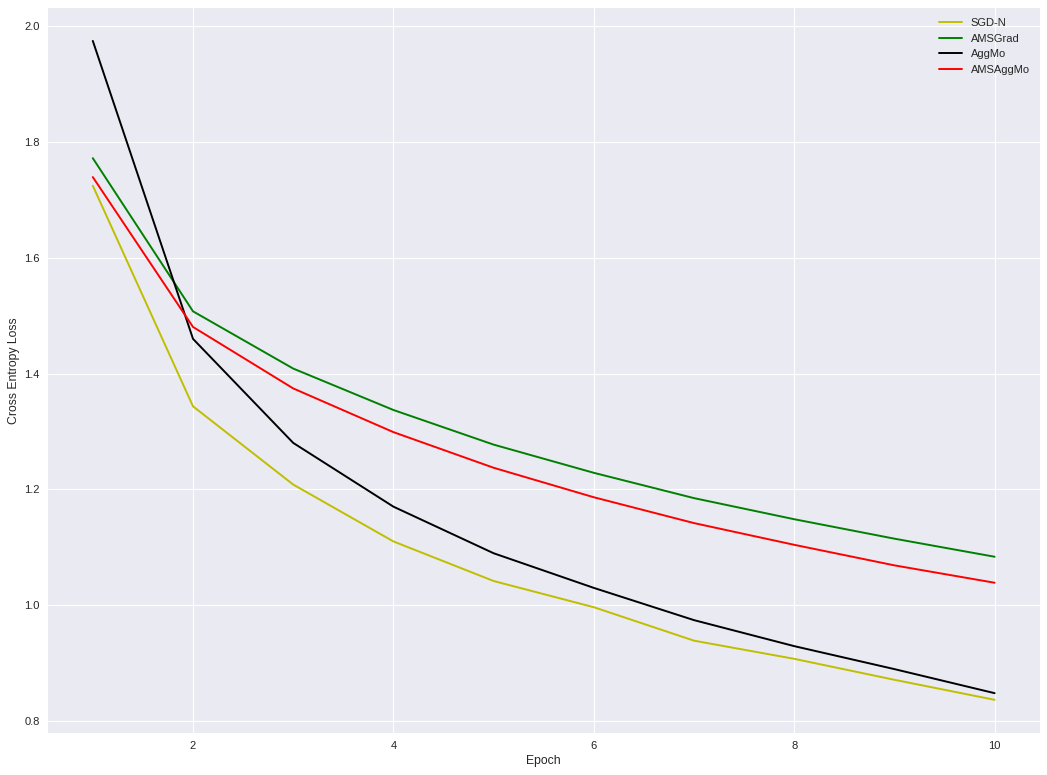

In [12]:
sgd_loss.shape = (epochs,1)
amsg_loss.shape = (epochs,1)
aggmo_loss.shape = (epochs,1)
amsaggmo_loss.shape = (epochs,1)


x = np.linspace(1,epochs, num=epochs)
x.shape = (epochs,1)

plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x,sgd_loss,'y',label ="SGD-N")
plt.plot(x,amsg_loss,'g',label="AMSGrad")
plt.plot(x,aggmo_loss,'k',label="AggMo")
plt.plot(x,amsaggmo_loss,'r',label="AMSAggMo")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()